In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [85]:
args = {'lr':0.01,
        'train epochs':1000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'input features':30,
        'train criterion':nn.MSELoss(),
        'test criterion':nn.L1Loss(),
        'correlation':0.2
        }

Data Prep

In [86]:
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [87]:
df = pd.read_excel('wide_range.xlsx')

In [88]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

Feature Selection

In [89]:
'''
for layer in layers:
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['input features'])

    inputs = X.copy()
    target = y[layer['col']]

    X_selected = rfe.fit_transform(inputs, target)
    selected_feature_indices = rfe.get_support(indices=True)
    
    features = []
    for i in selected_feature_indices:
        features.append(X.columns[i])

    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()}:\n {features}\n')'''

'''
for layer in layers:
    if layer['layer'] < 9:
        layer['features'] = X.columns[:args['input features']]
    else: 
        layer['features'] = X.columns[-args['input features']:]
'''

for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]

    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
        
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')


Features for Layer 1 (19):
 [3.95e-06, 4e-06, 3.9e-06, 4.05e-06, 3.85e-06, 3.8e-06, 4.1e-06, 3.75e-06, 4.15e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06]

Features for Layer 2 (19):
 [4.05e-06, 4e-06, 4.1e-06, 3.85e-06, 3.9e-06, 3.95e-06, 3.8e-06, 4.15e-06, 3.75e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06]

Features for Layer 3 (20):
 [4.2e-06, 4.15e-06, 4.25e-06, 3.75e-06, 4.1e-06, 3.8e-06, 4.3e-06, 4.05e-06, 3.85e-06, 3.9e-06, 4e-06, 4.55e-06, 3.95e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06, 4.7e-06]

Features for Layer 4 (20):
 [4.6e-06, 4.55e-06, 4.5e-06, 4.3e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.25e-06, 4.65e-06, 4.2e-06, 4.15e-06, 3.75e-06, 4.7e-06, 4.1e-06, 3.8e-06, 3.85e-06, 4.05e-06, 3.9e-06, 4e-06, 3.95e-06]

Features for Layer 5 (21):
 [4.6e-06, 4.5e-06, 4.55e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.3e-06, 4.65e-06, 4.25e-06, 4.2e-06, 4.7e-06, 4.15e-06, 3.7

In [90]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X_noisy = X + noise

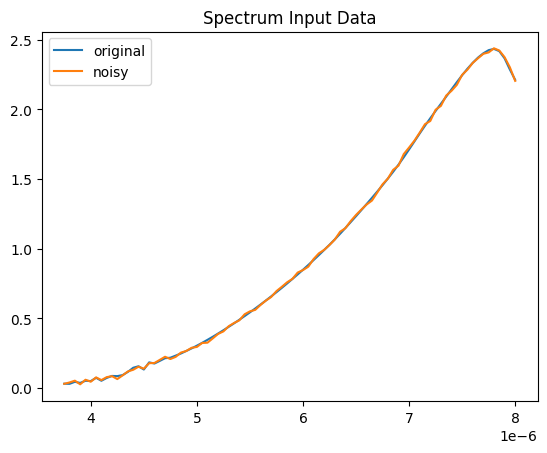

In [91]:
plt.title('Spectrum Input Data')
plt.plot(X.iloc[0], label='original')
plt.plot(X_noisy.iloc[0], label='noisy')
plt.legend()
plt.show()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, train_size=args['train size'], random_state=101)

In [93]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [94]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForward, self).__init__()
        self.lin1 = nn.Linear(input_size, 18) 
        self.lin2 = nn.Linear(18, 15)
        self.lin3 = nn.Linear(15, 10)
        self.lin4 = nn.Linear(10, 5)
        self.lin_fin = nn.Linear(5, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = self.lin_fin(x)
        return x

In [95]:
criterion = args['train criterion']

In [96]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    model = FeedForward(input.size()[1], target.size()[1])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

    print(layer['col'])

    for epoch in range(args['train epochs']):
        outputs = model(input)

        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
epoch: 100, loss = 1753.365234375
epoch: 200, loss = 1154.877685546875
epoch: 300, loss = 653.5621948242188
epoch: 400, loss = 349.9617614746094
epoch: 500, loss = 223.34671020507812
epoch: 600, loss = 170.56785583496094
epoch: 700, loss = 153.89401245117188
epoch: 800, loss = 149.9068603515625
epoch: 900, loss = 148.6450958251953
epoch: 1000, loss = 147.8435516357422
best loss: 147.8435516357422 in epoch 1000

layer 2
epoch: 100, loss = 1929.8707275390625
epoch: 200, loss = 1263.4564208984375
epoch: 300, loss = 715.6709594726562
epoch: 400, loss = 355.1571960449219
epoch: 500, loss = 190.78475952148438
epoch: 600, loss = 168.69631958007812
epoch: 700, loss = 165.46231079101562
epoch: 800, loss = 162.8106689453125
epoch: 900, loss = 160.90347290039062
epoch: 1000, loss = 159.9321746826172
best loss: 159.9321746826172 in epoch 1000

layer 3
epoch: 100, loss = 2540.860595703125
epoch: 200, loss = 1529.4365234375
epoch: 300, loss = 851.5703125
epoch: 400, loss = 93.62549591064453


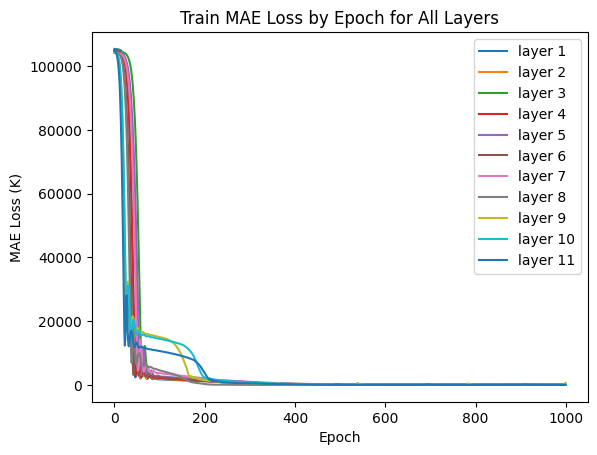

In [97]:
for layer in layers:
    plt.plot(layer['train losses'], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [98]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

layer 1 loss: 9.653059959411621
layer 2 loss: 10.545804977416992
layer 3 loss: 6.493180274963379
layer 4 loss: 7.865323066711426
layer 5 loss: 6.114865303039551
layer 6 loss: 6.6167378425598145
layer 7 loss: 6.145493030548096
layer 8 loss: 4.721676349639893
layer 9 loss: 21.710479736328125
layer 10 loss: 2.4378855228424072
layer 11 loss: 1.5466511249542236


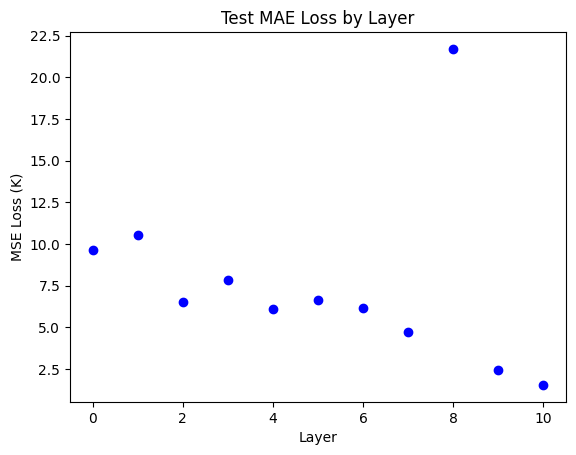

In [99]:
plt.plot(test_losses, 'bo')

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [100]:
def plot_comparison(pred, actual):
    plt.figure(figsize=(15, 5))
    plt.title("Temperature Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [101]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

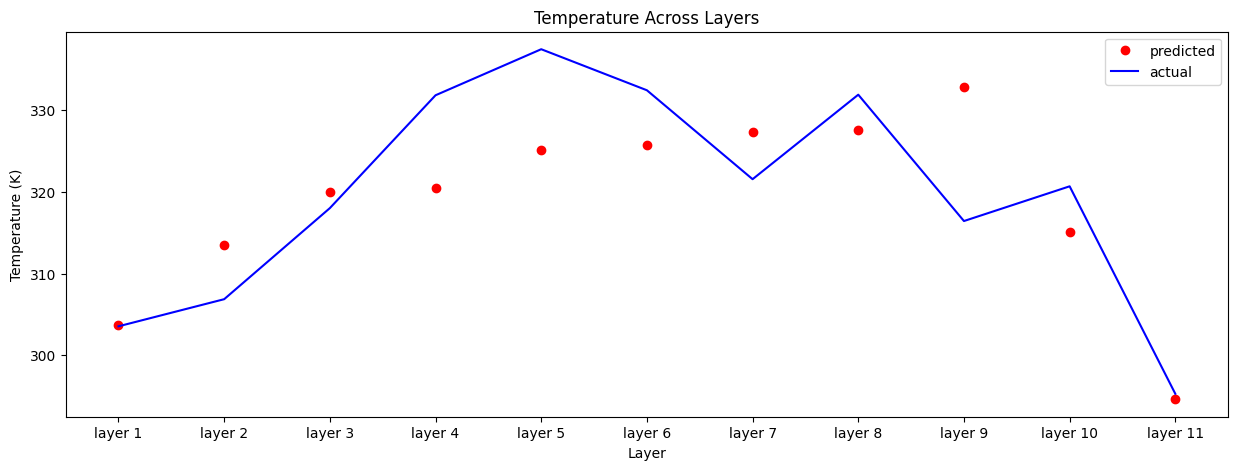

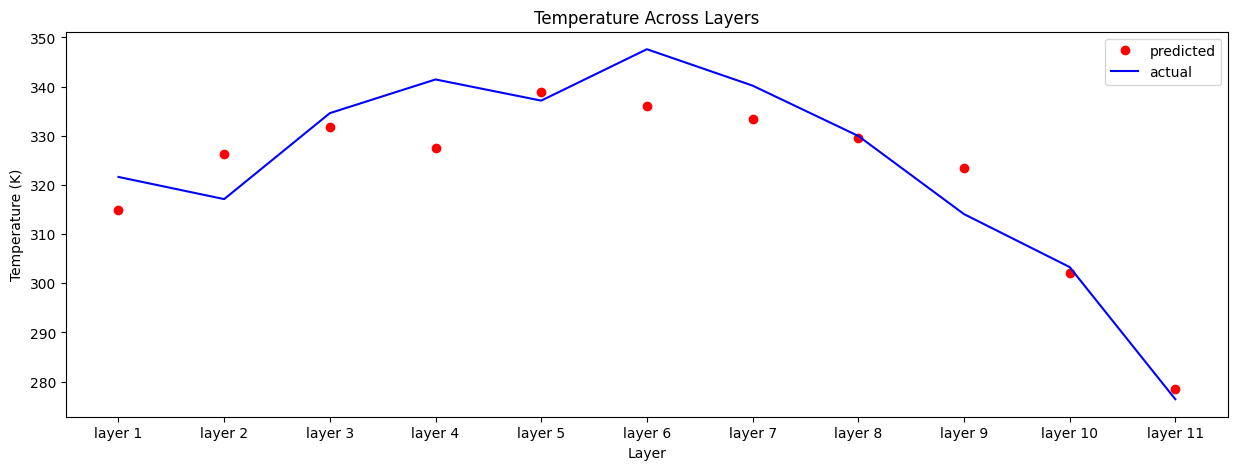

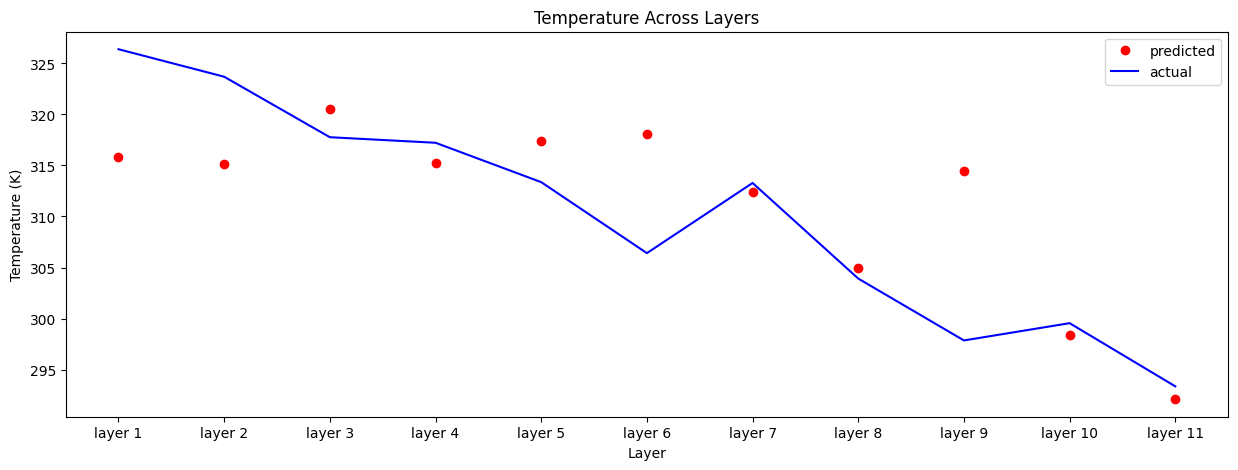

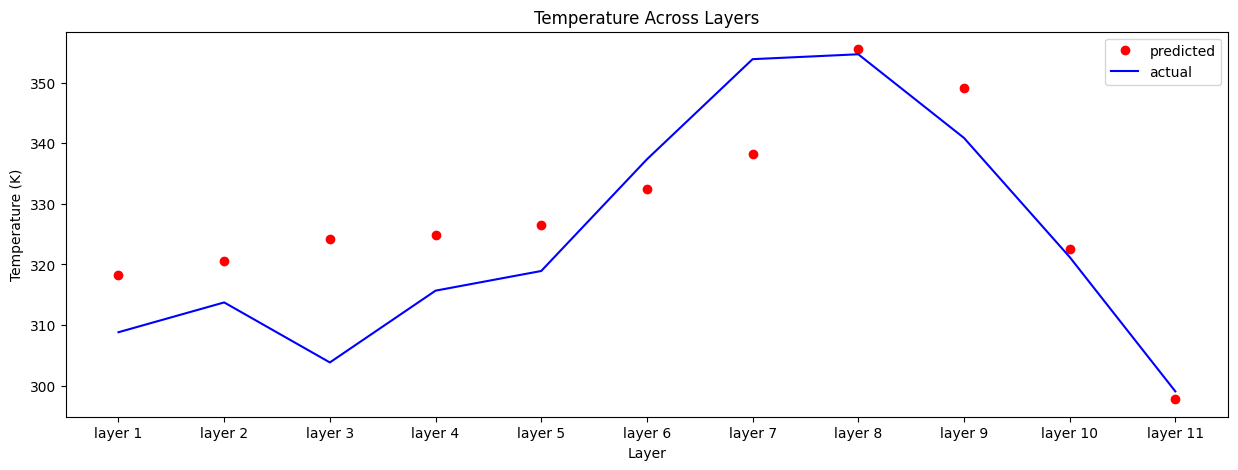

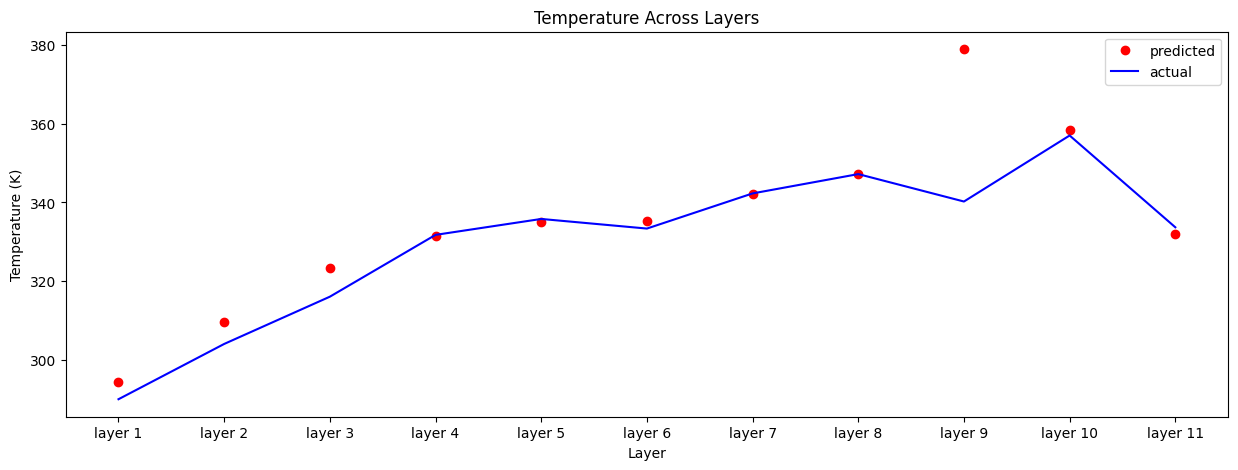

In [102]:


for i in range(0, len(y_test), int(len(y_test)/5)):
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual)